In [1]:
import tensorflow as tf
import waveflow as wf
import numpy as np
import pylab
from tensorflow.core.protobuf import rewriter_config_pb2

config = tf.ConfigProto()
config.allow_soft_placement = True
config.log_device_placement = True
config.gpu_options.per_process_gpu_memory_fraction = 0.3
## We turn off optimization here to make sure, that computations are done using CUDA implementation of op.
config.graph_options.optimizer_options.opt_level = -1
config.graph_options.rewrite_options.constant_folding = (rewriter_config_pb2.RewriterConfig.OFF)
config.graph_options.rewrite_options.arithmetic_optimization = (rewriter_config_pb2.RewriterConfig.OFF)
rf = np.load('usg1_sta_nitki_reduced.npy')

sess = tf.InteractiveSession(config = config)

sl1543 = wf.ultrasound.Probe(
  name = "sl1543",
  num_elements = 192,
  subaperture_size= 64,
  pitch = .21e-3,
  sampling_frequency=50e6,
  input_source=wf.io.NumpyArraySource(rf)
)

string_phantom = wf.physics.PhysicalEnv(
  speed_of_sound=1490.
)

/home/pjarosik/.conda/envs/waveflow/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


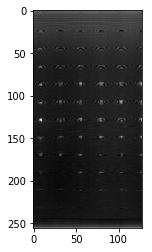

In [2]:
with wf.ultrasound.UltrasoundEnv(probe=sl1543, physical_env=string_phantom) as us_env, sess.graph.device('/device:GPU:0'):
  input = us_env.step()  
  # Event, Sample, Channel -> Event, Channel, Sample
  transposed = tf.transpose(input, perm=[0, 2, 1])
  reduced = wf.beamforming.sta(transposed, output_shape=(256, 128), start_depth=.005, us_env=us_env)
  transformed = wf.transforms.analytic_signal(tf.cast(reduced, dtype=tf.complex64), axis=0)
  frame = tf.abs(transformed)
  img = frame.eval()
  pylab.imshow(img, cmap='gray')

Computations were done on devbox (IFTR using NVidia GeForce GTX TITAN X, with CUDA ver. 8. 

In [7]:
import time

sta_flow_execution_time = []

with wf.ultrasound.UltrasoundEnv(probe=sl1543, physical_env=string_phantom) as us_env, sess.graph.device('/device:GPU:0'):
  input = us_env.step()  
  # Event, Sample, Channel -> Event, Channel, Sample
  transposed = tf.transpose(input, perm=[0, 2, 1])
  reduced = wf.beamforming.sta(transposed, output_shape=(256, 128), start_depth=.005, us_env=us_env)
  transformed = wf.transforms.analytic_signal(tf.cast(reduced, dtype=tf.complex64), axis=0)
  frame = tf.abs(transformed)
  for x in range(0, 500):
    start = time.time()
    img = frame.eval()
    sta_flow_execution_time.append(time.time()-start)
mean_exec = np.mean(sta_flow_execution_time)
frame_rate = 1/mean_exec
std_exec = np.std(sta_flow_execution_time)
print('mean flow execution time: %.4f (frame rate %.2f) +/- %.4f' % (mean_exec, frame_rate, std_exec))

mean flow execution time: 0.0085 (frame rate 118.23) +/- 0.0142
